#### Import Libraries

In [1]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random


import tensorflow as tf

2025-03-21 22:34:42.326157: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742596482.351756    7335 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742596482.359832    7335 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742596482.378437    7335 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742596482.378475    7335 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742596482.378477    7335 computation_placer.cc:177] computation placer alr

# Data Understanding

In [2]:
dataset_path = 'Dataset'
subsets = ['Training','Testing'] # Dataset divided into 2 subsets: training and testing

In [3]:
image_data = []

for subset in subsets: # goes through the 2 subsets training and testing
    subset_path = os.path.join(dataset_path,subset)
    diagnoses = os.listdir(subset_path) # Returns a list of diagnoses

    for diag in diagnoses: # iterates over the diagnoses
        diagnoses_folder = os.path.join(subset_path, diag )
        for img_file in os.listdir(diagnoses_folder):
            img_path = os.path.join(diagnoses_folder, img_file) # gets the image path within the diagnoses folder 
            with Image.open(img_path) as img: 
                width, height = img.size # Collects the width, height, and mode of the images
                mode = img.mode
                image_data.append({ # adds all the collected info for each image to the list
                    'subset':subset,
                    'diagnosis': diag,
                    'width': width,
                    'height': height,
                    'mode': mode,
                    'image': np.array(img) #image converted to numpy array
                })


df = pd.DataFrame(image_data)
    

In [4]:
df.head()

,subset,diagnosis,width,height,mode,image
0,Training,glioma,512,512,RGB,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,Training,glioma,512,512,RGB,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,Training,glioma,512,512,RGB,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,Training,glioma,512,512,RGB,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,Training,glioma,512,512,RGB,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


In [5]:
# Number of images for training and testing for each diagnosis
df.groupby(['subset', 'diagnosis']).size().unstack()


diagnosis,glioma,meningioma,notumor,pituitary
subset,,,,
Testing,300,306,405,300
Training,1321,1339,1595,1457


In [6]:
df_train = df[df['subset'] == 'Training']
df_test = df[df['subset'] == 'Testing']

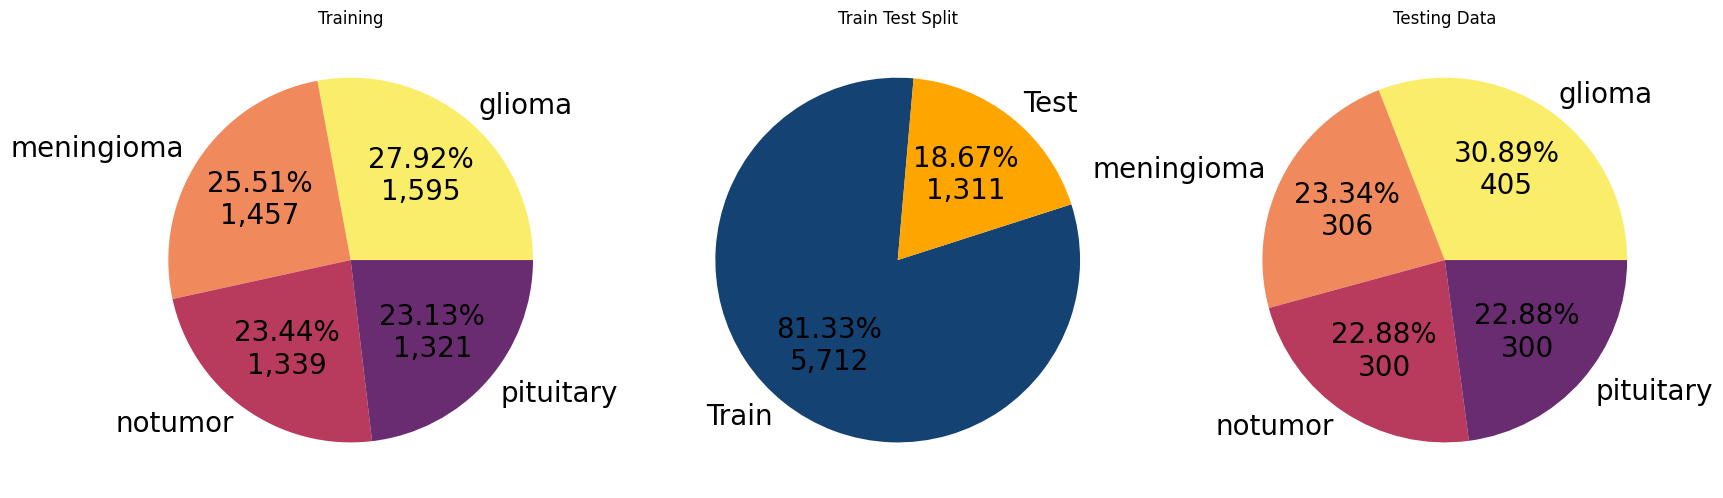

In [7]:
fig, ax = plt.subplots(ncols = 3,figsize=(20,14))

# training data split
ax[0].pie(df_train['diagnosis'].value_counts(), labels= pd.unique(df['diagnosis']),colors = ["#F9ED69", "#F08A5D", "#B83B5E", "#6A2C70"], 
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(df_train['diagnosis'].value_counts()) / 100),
    textprops={'fontsize': 20})
ax[0].set_title("Training")

# train test split
ax[1].set_title("Train Test Split")
ax[1].pie(
    [len(df_train), len(df_test)], 
    labels=['Train', 'Test'], 
    colors=['#144272', 'orange'],  # Fixed colors syntax and spelling
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * (len(df_train) + len(df_test)) / 100),
    startangle=85, 
    textprops={'fontsize': 20}
)

# testing data split
ax[2].set_title('Testing Data')
ax[2].pie(df_test['diagnosis'].value_counts(), labels= pd.unique(df['diagnosis']), colors=["#F9ED69", "#F08A5D", "#B83B5E", "#6A2C70"], 
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(df_test['diagnosis'].value_counts()) / 100),
    textprops={'fontsize': 20 })

plt.show()

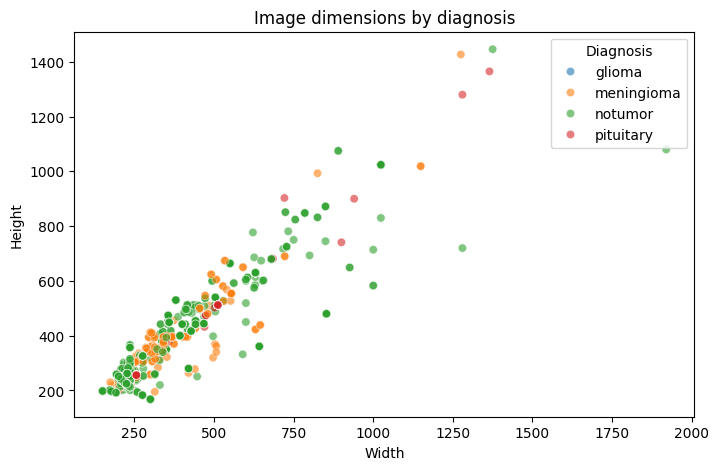

In [8]:
# Distribution of image dimensions 
plt.figure(figsize=(8,5))
sns.scatterplot(data = df, x='width',y='height', hue='diagnosis',alpha=0.6)
plt.title('Image dimensions by diagnosis')
plt.xlabel('Width')
plt.ylabel('Height')
plt.legend(title='Diagnosis')
plt.show()

In [9]:
# Displaying the mode of images, shows inconsistency across images
df['mode'].value_counts()

mode
RGB     3926
L       3093
RGBA       3
P          1
Name: count, dtype: int64

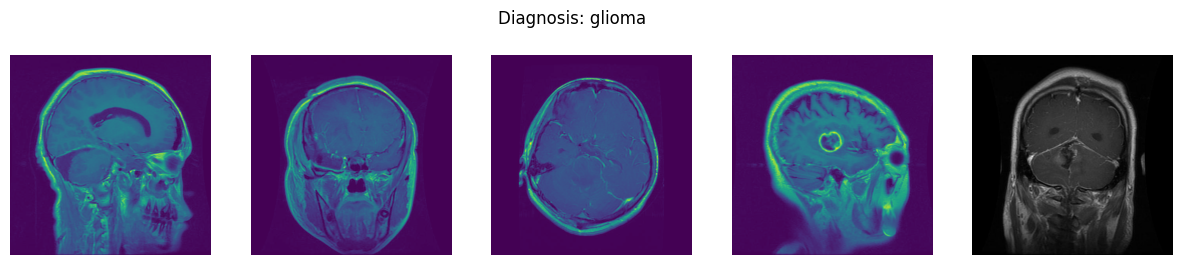

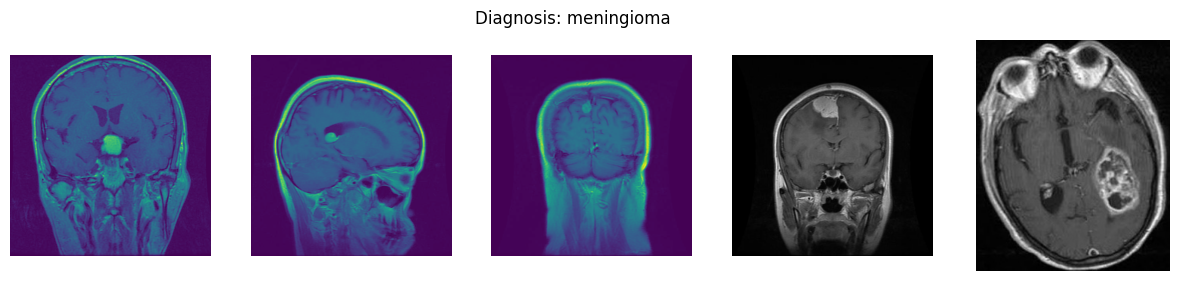

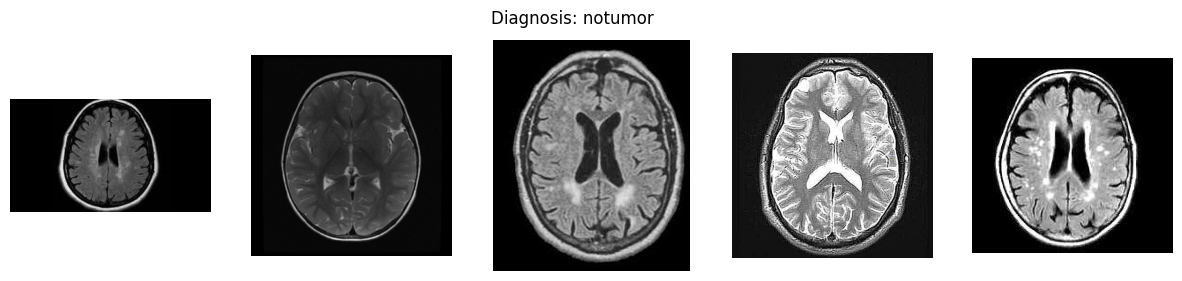

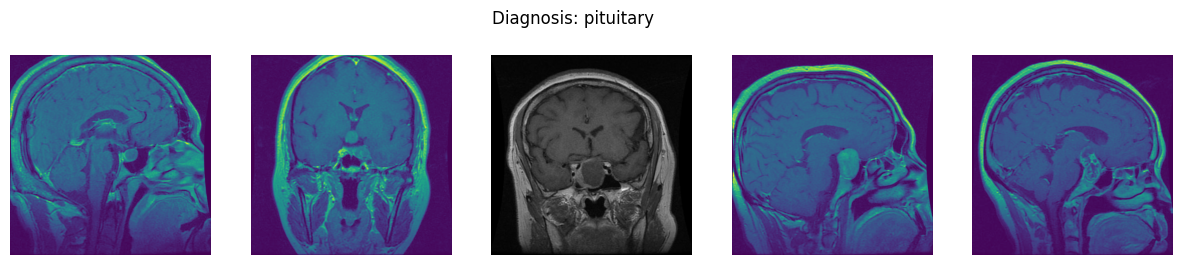

In [10]:
# Take 5 images from each diagnosis and visualise them, raw images without processing
for diag in diagnoses:
    samples = [item for item in image_data if item['diagnosis'] == diag]
    samples = random.sample(samples, k=5)  
    
    plt.figure(figsize=(15, 3))
    for i, item in enumerate(samples):
        plt.subplot(1, 5, i + 1)
        plt.imshow(item['image'])
        plt.axis('off')
    plt.suptitle(f"Diagnosis: {diag}")
    plt.show()


## Findings
The brain tumors dataset consists of 4 different brain diagnoses: Glioma, meningioma, pituitary and healthy (known as notumor). There are 7023 images; 5712 for training (81.33%) and 1311 for testing (18.67%) divided closely between the four diagnoses, also each subset is well divided among the 4 classes with a maximum of 27.92% for healthy brain and a minimum of 23.13% for glioma in the training set, with nearly similar results for the testing set indicating a good class balance to start with.

However, the image dimensions by diagnosis chart shows a huge variance in image dimensions that needs to be handled as part of the data preparation, we need to choose a common image size for all the images which may affect the performance of the model as certain parts of the brain may/may not be taken when resizing especially when it comes to locating tumors within the brain. Also the fact that some images have different color modes (3926 RGB and 3093 Greyscale) so we need to ensure consistency among shapes and channels to avoid potential issues.

# Data Preparation

In [11]:
train_dir = 'Dataset/Training' # train images directory
test_dir = 'Dataset/Testing'  # test images directory

#defining batch size and image size
batch_size= 32
image_size = 224

#load training data using image_dataset_from_directory
#source: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, 
    label_mode= 'categorical',
    validation_split= 0.2,                         # 20% of the training data will be used for training
    color_mode = 'grayscale',                      # Load images in grayscale
    batch_size = batch_size,                       # number of images processed in each batch
    image_size = (image_size,image_size),          # image size is 224x224 
    seed = 111,
    subset = 'training'                  
)

#load validation data using image_dataset_from_directory
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode= 'categorical',
    validation_split= 0.2,
    color_mode = 'grayscale',
    batch_size = batch_size,
    image_size = (image_size,image_size),
    shuffle = False,                                # Validation data isn't shuffled
    seed = 111,
    subset = 'validation'                 
)

#load validation data using image_dataset_from_directory
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    label_mode= 'categorical',
    color_mode = 'grayscale',
    batch_size = batch_size,
    image_size = (image_size, image_size),
    subset = None
)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.


I0000 00:00:1742596526.640139    7335 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.
